In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import libraries
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, load_dataset
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from jiwer import wer
import os
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt

2024-11-07 22:46:22.821346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 22:46:22.833397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 22:46:22.851473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 22:46:22.851494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 22:46:22.863397: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# Clone Spoken-SQuAD repository
def setup_data():
    if not os.path.exists("Spoken-SQuAD"):
        os.makedirs("Spoken-SQuAD")
        print("Creating 'Spoken-SQuAD' directory and cloning repository...")
        os.system("git clone https://github.com/chiahsuan156/Spoken-SQuAD.git Spoken-SQuAD")
        print("Spoken-SQuAD repository cloned successfully into 'Spoken-SQuAD' directory.")

setup_data()

In [3]:
# Load the tokenizer
print("Loading tokenizer...")
model_checkpoint = "bert-base-uncased"  # Can be replaced with other pre-trained models
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
print("Tokenizer loaded successfully.")

Loading tokenizer...
Tokenizer loaded successfully.


In [4]:
# Load and convert data into a Hugging Face Dataset if not already
print("Loading dataset...")
train_dataset = pd.read_json("Spoken-SQuAD/spoken_train-v1.1.json")
train_dataset = Dataset.from_pandas(train_dataset)

test_dataset = pd.read_json("Spoken-SQuAD/spoken_test-v1.1.json")
test_dataset = Dataset.from_pandas(test_dataset)

print("Dataset loaded successfully.")

Loading dataset...
Dataset loaded successfully.


In [5]:
# Prepare training features function
def prepare_training_features(examples):
    questions = []
    contexts = []
    answers = []
    
    for entry in examples["data"]:
        for paragraph in entry["paragraphs"]:
            context = paragraph["context"]
            for qa in paragraph["qas"]:
                question = qa["question"]
                if len(qa["answers"]) > 0:
                    questions.append(question)
                    contexts.append(context)
                    answers.append(qa["answers"][0])
    
    # Check if lists are empty
    if not questions or not contexts or not answers:
        print("One of the lists is empty, skipping tokenization.")
        return {}
    
    # Tokenize inputs
    tokenized_examples = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=512,  
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    
    # Processing labels
    start_positions = []
    end_positions = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Identify the corresponding example
        sample_index = sample_mapping[i]
        answer = answers[sample_index]
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])
        
        # Get the offsets for the current tokenized input
        offsets = tokenized_examples["offset_mapping"][i]
        sequence_ids = tokenized_examples.sequence_ids(i)
        
        # Find the start and end of the context in the tokenized input
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
        
        # If the answer is outside the context, label start and end as 0
        if not (offsets[context_start][0] <= start_char < offsets[context_end][1]):
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise, set the token start and end positions of the answer
            token_start_index = context_start
            token_end_index = context_end
            
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)
            
            while token_end_index > 0 and offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)
    
    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    
    return tokenized_examples

In [6]:
# Training and validation dataset
print("Processing training and validation dataset...")
train_dataset = train_dataset.map(prepare_training_features, batched=True, remove_columns=train_dataset.column_names)
val_dataset = test_dataset.map(prepare_training_features, batched=True, remove_columns=test_dataset.column_names)
print("Training and validation dataset processed successfully.")

Processing training and validation dataset...


Map:   0%|          | 0/442 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Training and validation dataset processed successfully.


In [7]:
# Print the first row for verification
print("First processed training row:")
print(train_dataset[0])

First processed training row:
{'input_ids': [101, 2054, 2003, 1999, 2392, 1997, 1996, 10289, 8214, 2364, 2311, 1029, 102, 6549, 2135, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 2082, 8514, 2003, 1996, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1999, 5307, 2009, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 10439, 14995, 6924, 2007, 1996, 5722, 1998, 1996, 2919, 2033, 5004, 3415, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 10047, 2984, 1999, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 2358, 16595, 9648, 4674, 2145, 5255, 7763, 5595, 2809, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 2093, 11342, 1999, 1996, 2751, 8514, 2003, 2004, 3722, 2715, 2962, 6231, 1997, 2984

In [8]:
# Model initialization
print("Initializing model...")
model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased')
print("Model initialized successfully.")

Initializing model...


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized successfully.


In [9]:
# DataLoader setup
print("Setting up DataLoaders...")
def collate_fn(batch):
    input_ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(d["input_ids"]) for d in batch], batch_first=True)
    attention_mask = torch.nn.utils.rnn.pad_sequence([torch.tensor(d["attention_mask"]) for d in batch], batch_first=True)
    token_type_ids = torch.nn.utils.rnn.pad_sequence([torch.tensor(d["token_type_ids"]) for d in batch], batch_first=True)
    start_positions = torch.tensor([d["start_positions"] for d in batch])
    end_positions = torch.tensor([d["end_positions"] for d in batch])
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "token_type_ids": token_type_ids,
        "start_positions": start_positions,
        "end_positions": end_positions
    }

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)
print("DataLoaders set up successfully.")

Setting up DataLoaders...
DataLoaders set up successfully.


In [10]:
# Optimizer setup
print("Setting up optimizer and scheduler...")
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 10  
total_steps = len(train_dataloader) * num_epochs  # Total steps for specified epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
print("Optimizer and scheduler set up successfully.")

Setting up optimizer and scheduler...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Optimizer and scheduler set up successfully.


In [11]:
# Check if CUDA is available
print("Checking device...")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(f"Using device: {device}")

Checking device...
Using device: cuda


In [12]:
print(train_dataset.column_names)
print(val_dataset.column_names)

['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions']
['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions']


In [13]:
# Function to calculate the evaluation metrics Word Error Rate (WER)
def calculate_wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
    for i in range(len(ref_words) + 1):
        d[i, 0] = i
    for j in range(len(hyp_words) + 1):
        d[0, j] = j
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i - 1] == hyp_words[j - 1]:
                d[i, j] = d[i - 1, j - 1]
            else:
                substitution = d[i - 1, j - 1] + 1
                insertion = d[i, j - 1] + 1
                deletion = d[i - 1, j] + 1
                d[i, j] = min(substitution, insertion, deletion)
    wer = d[len(ref_words), len(hyp_words)] / len(ref_words) if len(ref_words) > 0 else 0
    return wer

In [14]:
# Training loop with validation after each epoch
gradient_accumulation_steps = 2  # Number of steps to accumulate gradients
for epoch in range(num_epochs):
    print(f"Starting training epoch {epoch + 1}...")
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}")):
        input_ids = batch["input_ids"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)
        
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

    # Evaluation after each epoch
    print(f"Starting evaluation for epoch {epoch + 1}...")
    model.eval()
    total_eval_loss = 0
    wer_total = 0
    num_eval_examples = 0
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Evaluating Epoch {epoch + 1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, start_positions=start_positions, end_positions=end_positions)
            loss = outputs.loss
            total_eval_loss += loss.item()

            # Calculate Word Error Rate (WER)
            start_preds = torch.argmax(outputs.start_logits, dim=1)
            end_preds = torch.argmax(outputs.end_logits, dim=1)
            predictions = []
            references = []
            for i in range(input_ids.size(0)):
                pred_start, pred_end = start_preds[i].item(), end_preds[i].item()
                predicted_text = tokenizer.decode(input_ids[i][pred_start:pred_end + 1], skip_special_tokens=True)
                predictions.append(predicted_text)
                ref_start, ref_end = start_positions[i].item(), end_positions[i].item()
                reference_text = tokenizer.decode(input_ids[i][ref_start:ref_end + 1], skip_special_tokens=True)
                references.append(reference_text)
            
            for ref, pred in zip(references, predictions):
                if ref.strip() and pred.strip():
                    wer_total += calculate_wer(ref, pred)
                    num_eval_examples += 1
    
    avg_eval_loss = total_eval_loss / len(val_dataloader)
    avg_wer = wer_total / num_eval_examples if num_eval_examples > 0 else 0
    print(f"Validation Loss after Epoch {epoch + 1}: {avg_eval_loss:.4f}, WER: {avg_wer:.4f}")

Starting training epoch 1...


Training Epoch 1: 100%|██████████| 2321/2321 [13:53<00:00,  2.79it/s]


Epoch 1/10, Training Loss: 1.9236
Starting evaluation for epoch 1...


Evaluating Epoch 1: 100%|██████████| 336/336 [00:48<00:00,  6.88it/s]


Validation Loss after Epoch 1: 1.5725, WER: 2.2677
Starting training epoch 2...


Training Epoch 2: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 2/10, Training Loss: 1.1200
Starting evaluation for epoch 2...


Evaluating Epoch 2: 100%|██████████| 336/336 [00:48<00:00,  6.89it/s]


Validation Loss after Epoch 2: 1.5048, WER: 1.8827
Starting training epoch 3...


Training Epoch 3: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 3/10, Training Loss: 0.7886
Starting evaluation for epoch 3...


Evaluating Epoch 3: 100%|██████████| 336/336 [00:48<00:00,  6.89it/s]


Validation Loss after Epoch 3: 1.5817, WER: 1.6705
Starting training epoch 4...


Training Epoch 4: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 4/10, Training Loss: 0.5613
Starting evaluation for epoch 4...


Evaluating Epoch 4: 100%|██████████| 336/336 [00:48<00:00,  6.89it/s]


Validation Loss after Epoch 4: 1.8357, WER: 1.3809
Starting training epoch 5...


Training Epoch 5: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 5/10, Training Loss: 0.4099
Starting evaluation for epoch 5...


Evaluating Epoch 5: 100%|██████████| 336/336 [00:48<00:00,  6.87it/s]


Validation Loss after Epoch 5: 2.0193, WER: 1.6001
Starting training epoch 6...


Training Epoch 6: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 6/10, Training Loss: 0.3061
Starting evaluation for epoch 6...


Evaluating Epoch 6: 100%|██████████| 336/336 [00:48<00:00,  6.86it/s]


Validation Loss after Epoch 6: 2.1449, WER: 1.4585
Starting training epoch 7...


Training Epoch 7: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 7/10, Training Loss: 0.2281
Starting evaluation for epoch 7...


Evaluating Epoch 7: 100%|██████████| 336/336 [00:48<00:00,  6.86it/s]


Validation Loss after Epoch 7: 2.3659, WER: 1.7053
Starting training epoch 8...


Training Epoch 8: 100%|██████████| 2321/2321 [13:54<00:00,  2.78it/s]


Epoch 8/10, Training Loss: 0.1762
Starting evaluation for epoch 8...


Evaluating Epoch 8: 100%|██████████| 336/336 [00:48<00:00,  6.90it/s]


Validation Loss after Epoch 8: 2.4854, WER: 1.7573
Starting training epoch 9...


Training Epoch 9: 100%|██████████| 2321/2321 [13:53<00:00,  2.79it/s]


Epoch 9/10, Training Loss: 0.1409
Starting evaluation for epoch 9...


Evaluating Epoch 9: 100%|██████████| 336/336 [00:48<00:00,  6.91it/s]


Validation Loss after Epoch 9: 2.6362, WER: 1.7432
Starting training epoch 10...


Training Epoch 10: 100%|██████████| 2321/2321 [13:53<00:00,  2.79it/s]


Epoch 10/10, Training Loss: 0.1137
Starting evaluation for epoch 10...


Evaluating Epoch 10: 100%|██████████| 336/336 [00:48<00:00,  6.92it/s]

Validation Loss after Epoch 10: 2.7365, WER: 1.8796


In [15]:
# Save model at the end
model.save_pretrained("./BERT_trained_model")
tokenizer.save_pretrained("./BERT_trained_model")
print(f"Model and tokenizer saved")

Model and tokenizer saved


Final Evaluation on Test Set (no noise): 100%|██████████| 336/336 [00:48<00:00,  6.92it/s]


Final Test Set (no noise) Word Error Rate (WER): 1.8796


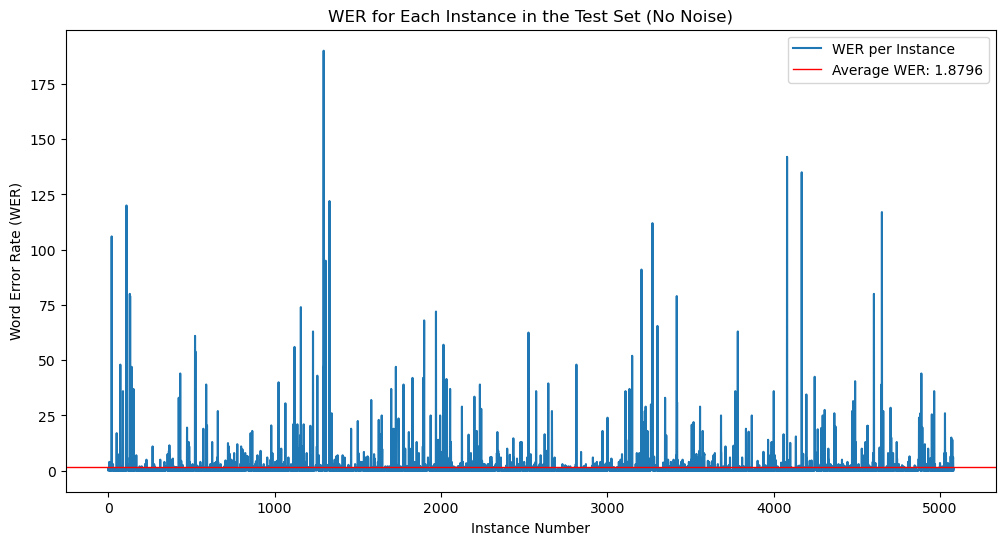

In [16]:
# Final Evaluation on Test Set (No Noise)

# Lists to store WER values for each instance
wer_per_instance = []

# Final evaluation with WER calculation
model.eval()
total_test_loss = 0
wer_total = 0
num_wer_examples = 0
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Final Evaluation on Test Set (no noise)"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_test_loss += loss.item()

        # Decode predictions and references
        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds = torch.argmax(outputs.end_logits, dim=1)

        for i in range(input_ids.size(0)):
            pred_start, pred_end = start_preds[i].item(), end_preds[i].item()
            predicted_text = tokenizer.decode(input_ids[i][pred_start:pred_end + 1], skip_special_tokens=True)
            ref_start, ref_end = start_positions[i].item(), end_positions[i].item()
            reference_text = tokenizer.decode(input_ids[i][ref_start:ref_end + 1], skip_special_tokens=True)

            predictions.append(predicted_text)
            references.append(reference_text)

            # Calculate WER for current instance
            if reference_text.strip() and predicted_text.strip():  # Ensure neither reference nor prediction is empty
                current_wer = calculate_wer(reference_text, predicted_text)
                wer_per_instance.append(current_wer)
                wer_total += current_wer
                num_wer_examples += 1

# Calculate average WER
avg_wer = wer_total / num_wer_examples if num_wer_examples > 0 else 0
print(f"Final Test Set (no noise) Word Error Rate (WER): {avg_wer:.4f}")

# Plot WER for each instance and average WER as a horizontal line
plt.figure(figsize=(12, 6))
plt.plot(range(len(wer_per_instance)), wer_per_instance, label='WER per Instance')
plt.axhline(y=avg_wer, color='r', linestyle='-', linewidth=1, label=f'Average WER: {avg_wer:.4f}')
plt.xlabel('Instance Number')
plt.ylabel('Word Error Rate (WER)')
plt.title('WER for Each Instance in the Test Set (No Noise)')
plt.legend()
plt.show()

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Final Evaluation on Test Set (Noise v1): 100%|██████████| 336/336 [00:48<00:00,  6.93it/s]


Final Test Set (Noise v1) Word Error Rate (WER): 1.8282


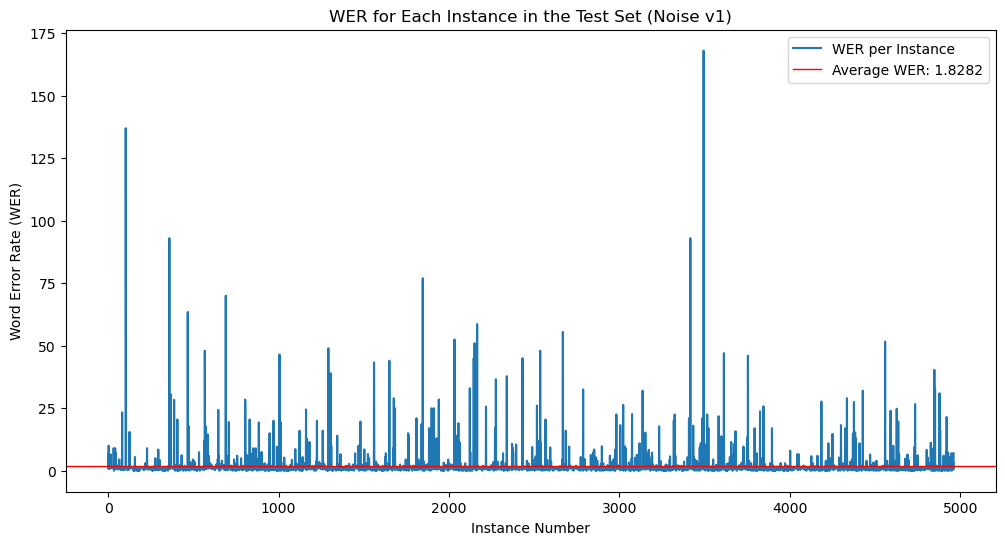

In [17]:
# Final Evaluation on Test Set (Noise v1 - WER 44 test dataset)

test_dataset_wer44 = pd.read_json("Spoken-SQuAD/spoken_test-v1.1_WER44.json")
test_dataset_wer44 = Dataset.from_pandas(test_dataset_wer44)
test_dataset_wer44 = test_dataset_wer44.map(prepare_training_features, batched=True, remove_columns=test_dataset_wer44.column_names)
test_wer44_dataloader = DataLoader(test_dataset_wer44, batch_size=16, collate_fn=collate_fn)

# Lists to store WER values for each instance
wer_per_instance = []

# Final evaluation with WER calculation
model.eval()
total_test_loss = 0
wer_total = 0
num_wer_examples = 0
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_wer44_dataloader, desc="Final Evaluation on Test Set (Noise v1)"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_test_loss += loss.item()

        # Decode predictions and references
        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds = torch.argmax(outputs.end_logits, dim=1)

        for i in range(input_ids.size(0)):
            pred_start, pred_end = start_preds[i].item(), end_preds[i].item()
            predicted_text = tokenizer.decode(input_ids[i][pred_start:pred_end + 1], skip_special_tokens=True)
            ref_start, ref_end = start_positions[i].item(), end_positions[i].item()
            reference_text = tokenizer.decode(input_ids[i][ref_start:ref_end + 1], skip_special_tokens=True)

            predictions.append(predicted_text)
            references.append(reference_text)

            # Calculate WER for current instance
            if reference_text.strip() and predicted_text.strip():  # Ensure neither reference nor prediction is empty
                current_wer = calculate_wer(reference_text, predicted_text)
                wer_per_instance.append(current_wer)
                wer_total += current_wer
                num_wer_examples += 1

# Calculate average WER
avg_wer = wer_total / num_wer_examples if num_wer_examples > 0 else 0
print(f"Final Test Set (Noise v1) Word Error Rate (WER): {avg_wer:.4f}")

# Plot WER for each instance and average WER as a horizontal line
plt.figure(figsize=(12, 6))
plt.plot(range(len(wer_per_instance)), wer_per_instance, label='WER per Instance')
plt.axhline(y=avg_wer, color='r', linestyle='-', linewidth=1, label=f'Average WER: {avg_wer:.4f}')
plt.xlabel('Instance Number')
plt.ylabel('Word Error Rate (WER)')
plt.title('WER for Each Instance in the Test Set (Noise v1)')
plt.legend()
plt.show()

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

Final Evaluation on Test Set (Noise v2): 100%|██████████| 336/336 [00:48<00:00,  6.93it/s]


Final Test Set (Noise v2) Word Error Rate (WER): 1.9118


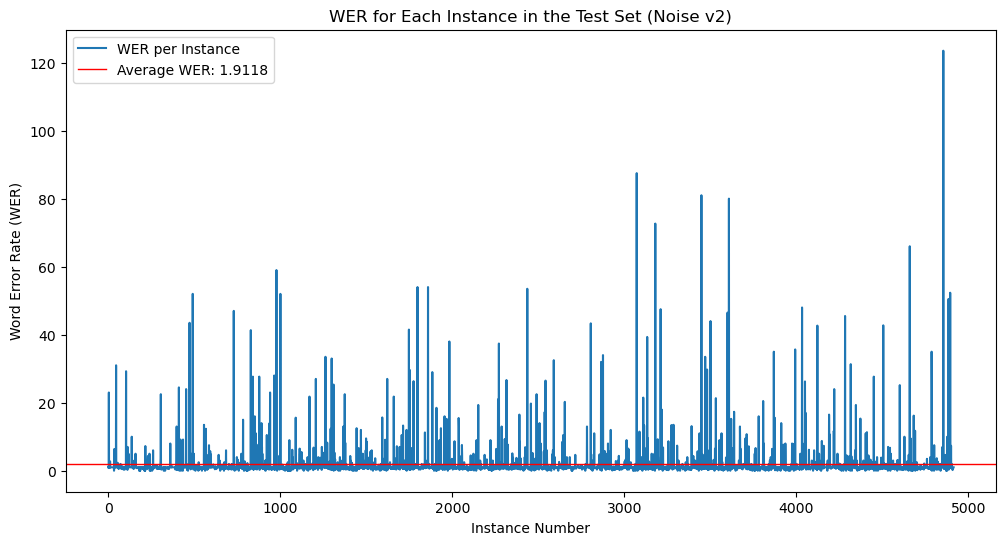

In [18]:
# Final Evaluation on Test Set (Noise v2 - WER 54 test dataset)

test_dataset_wer54 = pd.read_json("Spoken-SQuAD/spoken_test-v1.1_WER54.json")
test_dataset_wer54 = Dataset.from_pandas(test_dataset_wer54)
test_dataset_wer54 = test_dataset_wer54.map(prepare_training_features, batched=True, remove_columns=test_dataset_wer54.column_names)
test_wer54_dataloader = DataLoader(test_dataset_wer54, batch_size=16, collate_fn=collate_fn)

# Lists to store WER values for each instance
wer_per_instance = []

# Final evaluation with WER calculation
model.eval()
total_test_loss = 0
wer_total = 0
num_wer_examples = 0
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_wer54_dataloader, desc="Final Evaluation on Test Set (Noise v2)"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # Get model outputs
        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_test_loss += loss.item()

        # Decode predictions and references
        start_preds = torch.argmax(outputs.start_logits, dim=1)
        end_preds = torch.argmax(outputs.end_logits, dim=1)

        for i in range(input_ids.size(0)):
            pred_start, pred_end = start_preds[i].item(), end_preds[i].item()
            predicted_text = tokenizer.decode(input_ids[i][pred_start:pred_end + 1], skip_special_tokens=True)
            ref_start, ref_end = start_positions[i].item(), end_positions[i].item()
            reference_text = tokenizer.decode(input_ids[i][ref_start:ref_end + 1], skip_special_tokens=True)

            predictions.append(predicted_text)
            references.append(reference_text)

            # Calculate WER for current instance
            if reference_text.strip() and predicted_text.strip():  # Ensure neither reference nor prediction is empty
                current_wer = calculate_wer(reference_text, predicted_text)
                wer_per_instance.append(current_wer)
                wer_total += current_wer
                num_wer_examples += 1

# Calculate average WER
avg_wer = wer_total / num_wer_examples if num_wer_examples > 0 else 0
print(f"Final Test Set (Noise v2) Word Error Rate (WER): {avg_wer:.4f}")

# Plot WER for each instance and average WER as a horizontal line
plt.figure(figsize=(12, 6))
plt.plot(range(len(wer_per_instance)), wer_per_instance, label='WER per Instance')
plt.axhline(y=avg_wer, color='r', linestyle='-', linewidth=1, label=f'Average WER: {avg_wer:.4f}')
plt.xlabel('Instance Number')
plt.ylabel('Word Error Rate (WER)')
plt.title('WER for Each Instance in the Test Set (Noise v2)')
plt.legend()
plt.show()